In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.helper as cfh

In [3]:
# Tx
batch_size = 2
M = 4
frequencyShift = True

param = cfs.defaultParameters(precision='double')
print(param)

sps:	16
nChannels:	5
nPol:	2
time_steps:	4096
rollOff:	0.05
filterSpan:	128
PdBm:	1
optimizeP:	False
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>



In [4]:
x, idx, x_seed = cu.hotOnes((batch_size, param.nChannels, param.nPol, param.time_steps),(1,2,3,4,0),M)
print('x.shape: ', x.shape)
constellation = tx.qammod(M)
print('const mean power: ', np.mean(np.abs(constellation)**2))
print('const.shape: ', constellation.shape)

x.shape:  (2, 5, 2, 4096, 4)
const mean power:  0.9999999999999998
const.shape:  (1, 4)


In [5]:
X = tf.placeholder(tf.float32, shape=(None, param.nChannels, param.nPol, param.time_steps, M))
constellation_tf = tf.constant(constellation, param.complexType)

In [6]:
txSymbols = cfh.QAMencoder(X, constellation_tf, realOutput=False)
print(txSymbols)

signal = cfs.wdmTransmitter(txSymbols, param, frequencyShift=frequencyShift)
print(signal)

rxSymbols = cfs.wdmReceiver(signal, param, frequencyShift=frequencyShift)
print(rxSymbols)

Tensor("Squeeze:0", shape=(?, 5, 2, 4096), dtype=complex128)
Tensor("Sum:0", shape=(?, 2, 65536), dtype=complex128)
Tensor("mul_6:0", shape=(?, 5, 2, 4096), dtype=complex128)


In [7]:
# error counting
rxSymbols_tiled = tf.tile( tf.expand_dims( rxSymbols, -1 ), [1,1,1,1,M] )
rxIdx = tf.argmin( tf.abs( rxSymbols_tiled - constellation_tf ), axis=-1 )

txSymbols_tiled = tf.tile( tf.expand_dims( txSymbols, -1 ), [1,1,1,1,M] )
txIdx = tf.argmin( tf.abs( txSymbols_tiled - constellation_tf ), axis=-1 )

errors = tf.reduce_sum( tf.cast( tf.not_equal( txIdx, rxIdx ), tf.int32 ) )

In [8]:
session = tf.Session()
feedDict = { X: x }
[outErrors, outTxSymbols, outRxSymbols, outSignal] = session.run( [errors, txSymbols, rxSymbols, signal], feed_dict=feedDict )

In [9]:
print('Errors: ', outErrors)
print('MSE: ', np.mean(np.abs(outRxSymbols - outTxSymbols)**2))

Errors:  0
MSE:  4.42748752999248e-07


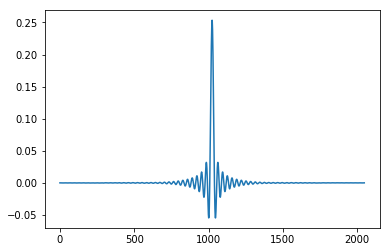

In [10]:
h = tx.rrcos( param.rollOff, param.sps, param.filterSpan )
plt.plot(h)

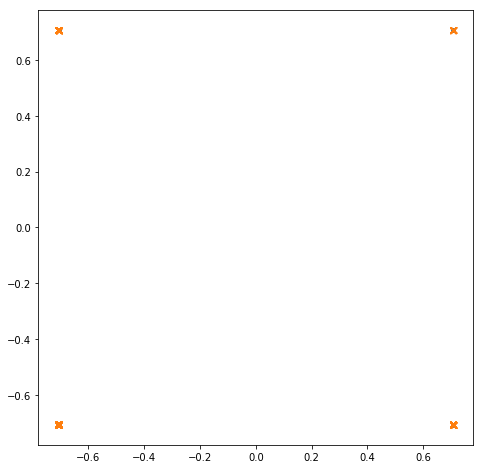

In [11]:
plt.figure(figsize=(8,8))
plt.plot( np.real(outTxSymbols[0,0,0,:]), np.imag(outTxSymbols[0,0,0,:]), '.' )
plt.plot( np.real(outRxSymbols[0,0,0,:]), np.imag(outRxSymbols[0,0,0,:]), 'x' )
plt.axis('square');

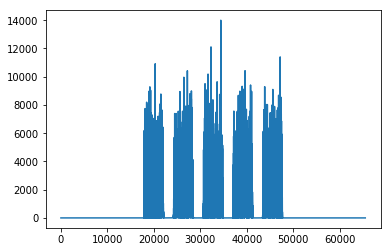

In [12]:
plt.plot( np.fft.fftshift( np.abs( np.fft.fft(outSignal[0,0,:]) )**2 ) );

In [13]:
def plotSymbols(a,b,fun):
    print(a.shape)
    print(b.shape)

    # Four axes, returned as a 2-d array
    f, axarr = plt.subplots(3, 2)
    axarr[0, 0].plot( fun(a[0,0,0,:]) )
    axarr[0, 1].plot( fun(a[0,1,0,:]) )
    axarr[1, 0].plot( fun(a[0,2,0,:]) )
    axarr[1, 1].plot( fun(a[0,3,0,:]) )
    axarr[2, 1].plot( fun(a[0,4,0,:]) )
    
    axarr[0, 0].plot( fun(b[0,0,0,:]), '.')
    axarr[0, 1].plot( fun(b[0,1,0,:]), '.')
    axarr[1, 0].plot( fun(b[0,2,0,:]), '.')
    axarr[1, 1].plot( fun(b[0,3,0,:]), '.')
    axarr[2, 1].plot( fun(b[0,4,0,:]), '.')
    
    axarr[0, 0].set_xlim([0,20])
    axarr[0, 1].set_xlim([0,20])
    axarr[1, 0].set_xlim([0,20])
    axarr[1, 1].set_xlim([0,20])
    axarr[2, 1].set_xlim([0,20])

(2, 5, 2, 4096)
(2, 5, 2, 4096)


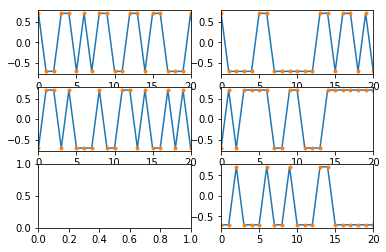

In [14]:
plotSymbols(outTxSymbols,outRxSymbols,np.real)

(2, 5, 2, 4096)
(2, 5, 2, 4096)


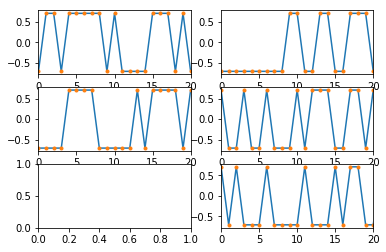

In [15]:
plotSymbols(outTxSymbols,outRxSymbols,np.imag)